In [133]:
import numpy as np
import matplotlib.pyplot as plt
import random

## Part 1

Consider a simple 5 × 5 gridworld problem, described below. This is the simplest abstraction of a reinforcement learning problem that allows us to benchmark and compare various learning algorithms to one another and is known as the ‘gridworld’ environment.

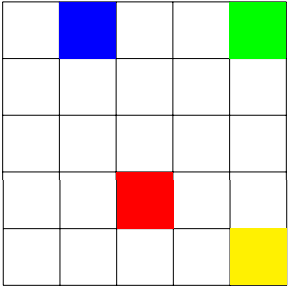

Each of the 25 cells of the gridworld represent a possible state of the world. An agent in the gridworld environment can take a step up, down, left or right. If the agent attempts to step off the grid, the location of the agent remains unchanged.

The blue, green, red and yellow squares represent special states at which the behaviour of the system is as follows. At the blue square, any action yields a reward of 5 and causes the agent to jump to the red square. At the green square, any action yields a reward of 2.5 and causes the agent to jump to either the yellow square or the red square with probability 0.5.

An attempt to step off the grid yields a reward of −0.5 and any move from a white square to another white square yields a reward of 0. Intuitively, an agent with a good policy should try to find the states with a high value, and exploit the rewards available at those states.

1. Consider a reward discount of γ = 0.95 and a policy which simply moves to one of the four directions with equal probability of 0.25. Estimate the value function for each of the states using (1) solving the system of Bellman equations explicitly (2) iterative policy evaluation (3) value iteration. Which states have the highest value? Does this surprise you?



In [134]:
Grid_size = 5

gridworld = np.zeros((Grid_size, Grid_size)) #Row, Columns

#Blue Square
gridworld[0][1] = 5 #Jump to Red

#Green Square
gridworld[0][4] = 2.5 #Jump to Yellow or Red with probability 0.5

step = np.array([[-1,0],[1,0],[0,-1],[0,1]]) #Up, #Down, #Left, #Right
step_c = ["Up", "Down", "Left", "Right"]
gamma = 0.95

In [135]:
def Reward_And_Transition(Current_Step, Action):

    if Current_Step == [0,1]:
        Next_Step = [3,2]
        Reward = 5
        return  Next_Step, Reward
    
    elif Current_Step == [0,4]:
        Next_Step = np.array([[4,4],[3,2]])[np.random.randint(2)]
        Reward = 2.5
        return  Next_Step, Reward

    Next_Step = Current_Step + Action

    if Next_Step[0] < 0 or Next_Step[0] > 4 or Next_Step[1] < 0 or Next_Step[1] > 4:
        Reward = -0.5
        return Current_Step, Reward
    Reward = 0

    return Next_Step, Reward   

#### (1) Bellman equations

$$V_{\pi}(i,j) =  \sum_{V(i,j)} \pi (a | V(i,j)) [r + \gamma V_{\pi}(next-state)]$$

In [136]:
V = np.zeros((Grid_size, Grid_size))

P = np.zeros((Grid_size**2, Grid_size**2))
b = np.zeros(Grid_size**2)

for i in range(Grid_size):
    for j in range(Grid_size):
        b_aux = 0 
        for k in range(step.shape[0]): 
            New_Step, Reward = Reward_And_Transition([i,j], step[k])
            if i == 0 and j == 4: #This if is because of the 0.5 probability from the green block
                P[Grid_size*i + j, Grid_size*3 + 2] += gamma * 0.5 
                P[Grid_size*i + j, Grid_size*4 + 4] += gamma * 0.5
                b_aux += Reward 
                break
            else:
                P[Grid_size*i + j, Grid_size*New_Step[0] + New_Step[1]] += gamma * 0.25 
                b_aux += Reward * 0.25
         
        b[Grid_size*i+j] =  b_aux

In [137]:
A = np.eye(Grid_size**2) - P

In [138]:
V = np.linalg.solve(A, b).reshape((Grid_size,Grid_size))
V.round(decimals=5)

array([[ 2.171  ,  4.73362,  2.07028,  1.26529,  1.77912],
       [ 1.11807,  1.78212,  1.1741 ,  0.73917,  0.56247],
       [ 0.16279,  0.47789,  0.35198,  0.11046, -0.18617],
       [-0.54699, -0.28473, -0.2804 , -0.43991, -0.74431],
       [-1.10788, -0.84937, -0.80799, -0.93799, -1.23723]])

In [139]:
np.max(V), np.argwhere(V == np.max(V))[0]

(4.733615602061509, array([0, 1], dtype=int64))

#### (2) Iterative Policy Evaluation

$V(s) \lhd \sum \pi(a|s) \sum P(s'|s,a)[R(s,a,s') + \gamma V(s')]$ 

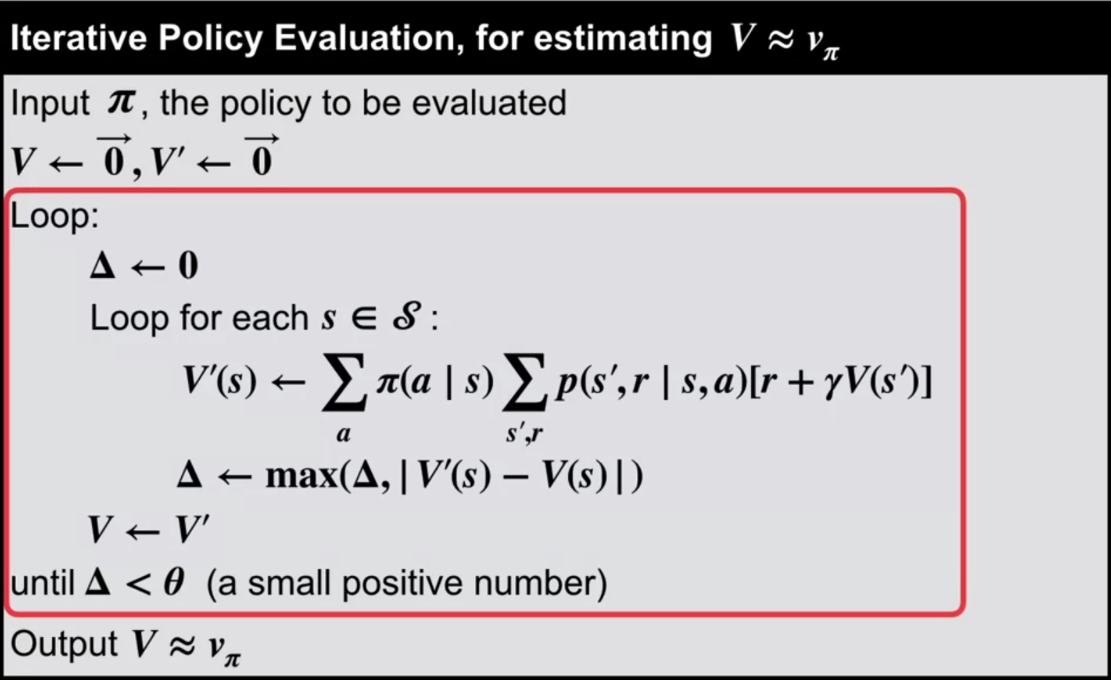

In [140]:
Value_Policy = np.zeros((Grid_size, Grid_size))
threshold = 0.0001

while 1:
    delta = 0
    for i in range(Grid_size):
        for j in range(Grid_size):
            Value_Policy_Current = Value_Policy[i,j]
            aux = 0
            #There are 4 directions            
            for k in range(step.shape[0]): 
                New_Step, Reward = Reward_And_Transition([i,j], step[k])
                aux += 0.25 * (Reward + gamma * Value_Policy[New_Step[0], New_Step[1]])
            Value_Policy[i,j] = aux
            delta = max(delta, abs(Value_Policy_Current - aux))
    if delta < threshold:
        break

In [141]:
Value_Policy

array([[ 2.17050023,  4.73318608,  2.06995862,  1.26499907,  1.77876358],
       [ 1.11751186,  1.78165863,  1.17373863,  0.73887487,  0.56217534],
       [ 0.16219516,  0.47739594,  0.35159659,  0.11014263, -0.18645191],
       [-0.54759651, -0.28523654, -0.28080673, -0.44023483, -0.74459742],
       [-1.10847771, -0.84987331, -0.80839978, -0.93832298, -1.23752305]])

In [142]:
np.max(Value_Policy), np.argwhere(Value_Policy == np.max(Value_Policy))[0]

(4.733186080070242, array([0, 1], dtype=int64))

#### (3) Value Iteration

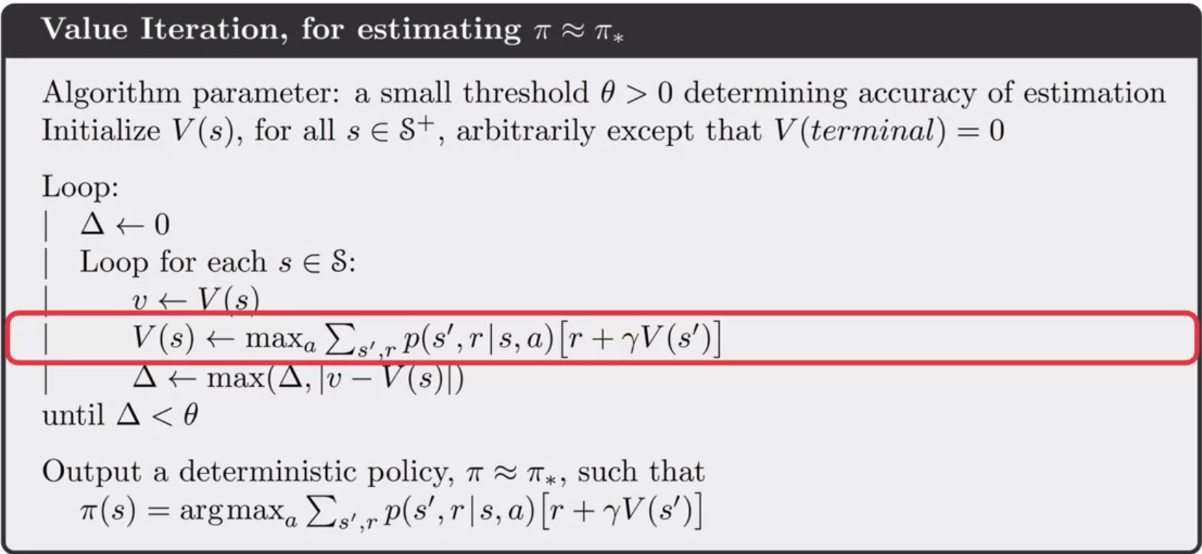

In [143]:
Value_Iteration = np.zeros((Grid_size, Grid_size))
threshold = 1e-100
while 1:
    delta = 0
    for i in range(Grid_size):
        for j in range(Grid_size):
            v = Value_Iteration[i,j]
            #There are 4 directions   
                
            for k in range(step.shape[0]): 
                New_Step, Reward = Reward_And_Transition([i,j], step[k])
                Value_Iteration[i,j] = max(Value_Iteration[i,j], 0.25 * (Reward + gamma * Value_Iteration[New_Step[0], New_Step[1]]))

            delta = max(delta, abs(v - Value_Iteration[i,j]))
            #print(Value_Iteration)
    if delta < threshold:        
        break

In [144]:
Value_Iteration.round(decimals=5)

array([[2.97100e-01, 1.25095e+00, 2.97100e-01, 1.48660e-01, 6.25950e-01],
       [7.05600e-02, 2.97100e-01, 7.05600e-02, 3.53100e-02, 1.48660e-01],
       [1.67600e-02, 7.05600e-02, 1.67600e-02, 8.39000e-03, 3.53100e-02],
       [3.98000e-03, 1.67600e-02, 3.98000e-03, 1.99000e-03, 8.39000e-03],
       [9.50000e-04, 3.98000e-03, 9.50000e-04, 4.70000e-04, 1.99000e-03]])

In [145]:
np.max(Value_Iteration), np.argwhere(Value_Iteration == np.max(Value_Iteration))[0]

(1.2509452710982731, array([0, 1], dtype=int64))

2. Determine the optimal policy for the gridworld problem by (1) explicitly solving the Bellman optimality equation (2) using policy iteration with iterative policy evaluation (3) policy improvement with value iteration.

#### (1) Policy Bellman equations

$$q_*(s,a) = E[R_{t+1} + \gamma v_*(S_{t+1}) | S_t = s, A_t = a]$$

In [146]:
V

array([[ 2.17100208,  4.7336156 ,  2.07028049,  1.26529444,  1.77912239],
       [ 1.1180732 ,  1.7821227 ,  1.17409573,  0.739174  ,  0.56246548],
       [ 0.16279444,  0.47788999,  0.35198379,  0.11045592, -0.18617038],
       [-0.54699155, -0.28473257, -0.28040463, -0.43990985, -0.7443105 ],
       [-1.10787684, -0.84936779, -0.80799244, -0.93799278, -1.23723244]])

In [147]:
def Get_Policy(V):
  Policy_Bellman = np.zeros((Grid_size, Grid_size,2))
  for i in range(Grid_size):
      for j in range(Grid_size):
          Policy_Bellman[i,j] = step[np.random.randint(4)]
  Policy_Bellman = Policy_Bellman.astype(int)
  for i in range(Grid_size):
      for j in range(Grid_size):
        Best_Value = 0
        for k in range(step.shape[0]):
          New_Step, Reward = Reward_And_Transition([i,j], step[k])
          New_Value = Reward + gamma * V[New_Step[0], New_Step[1]]
          if New_Value > Best_Value:
            Best_Value = New_Value
            Best_Action = step[k]
        Policy_Bellman[i,j] = Best_Action
  return Policy_Bellman

In [148]:
def Plot_Policy(Policy_Bellman):
    matrix = [['' for _ in range(Grid_size)] for _ in range(Grid_size)]
    matrix

    for i in range(Grid_size):
        for j in range(Grid_size):
            index = np.argmax(np.all(Policy_Bellman[i,j] == step, axis=1))
            matrix[i][j] = step_c[index]

    fig, ax = plt.subplots()
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])

    for i in range(Grid_size):
        for j in range(Grid_size):
            ax.text(j, i, matrix[i][j], va='center', ha='center')

    ax.set_xlim(-0.5, Grid_size - 0.5)
    ax.set_ylim(Grid_size - 0.5, -0.5)

    plt.show()

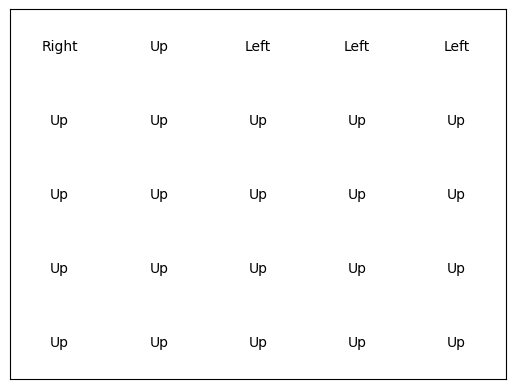

In [149]:
Policy_Bellman = Get_Policy(V)
Plot_Policy(Policy_Bellman)

#### (2) Policy Iteration with Iterative Policy Evaluation

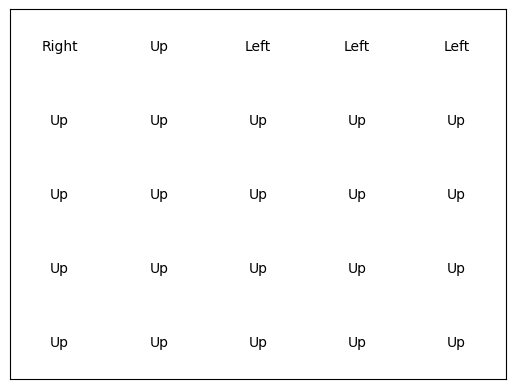

In [150]:
Policy_Iteration = Get_Policy(Value_Policy)
Plot_Policy(Policy_Iteration)

#### (3) Policy Value Iteration 

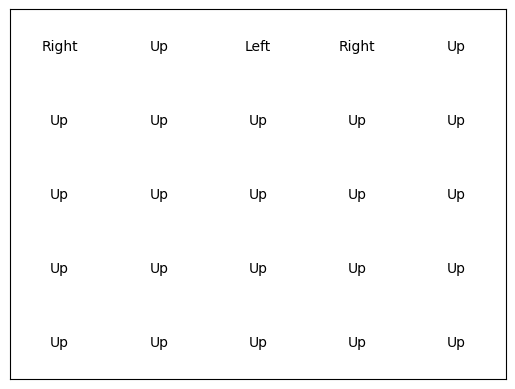

In [151]:
Policy_Iteration = Get_Policy(Value_Iteration)
Plot_Policy(Policy_Iteration)

## Part 2

Now let’s change the environment a bit by adding some terminal states represented as the black squares. This gives rise to episodes where termination occurs once the agent hits one of the black squares. We will also assume, unlike in Part 1, that any move from a white square to a white square yields a reward of -0.2.

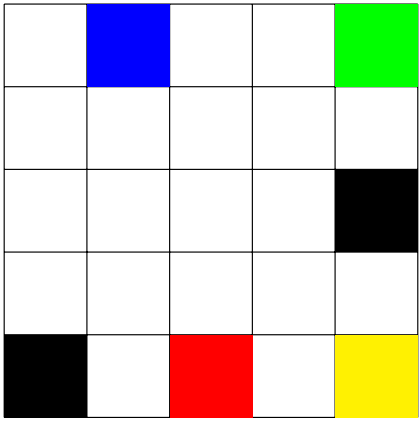

In [20]:
def Reward_And_Transition_Part_2(Current_Step, Action):

    if Current_Step == [0,1]:
        Next_Step = [3,2]
        Reward = 5
        return  Next_Step, Reward
    
    elif Current_Step == [0,4]:
        Next_Step = random.choice([[4,2],[4,4]])
        Reward = 2.5
        return  Next_Step, Reward
    
    elif Current_Step == [2,4]:
        Next_Step = [2,4]
        Reward = 0
        return  Next_Step, Reward
    
    elif Current_Step == [4,0]:
        Next_Step = [4,0]
        Reward = 0
        return  Next_Step, Reward
    
    Next_Step = list(np.add(Current_Step, Action))

    if Next_Step[0] < 0 or Next_Step[0] > 4 or Next_Step[1] < 0 or Next_Step[1] > 4:
        Reward = -0.5
        return Current_Step, Reward
    
    Reward = -0.2

    return Next_Step, Reward   

1. Use the Monte Carlo method with (1) exploring starts and (2) without exploring starts but the ϵ-soft approach to learn an optimal policy for this modified gridworld problem. Use the same discount factor of γ = 0.95 as you have in the Part 1 above. You can start with a policy with equiprobable moves.

##### Monte Carlo Exploring Start

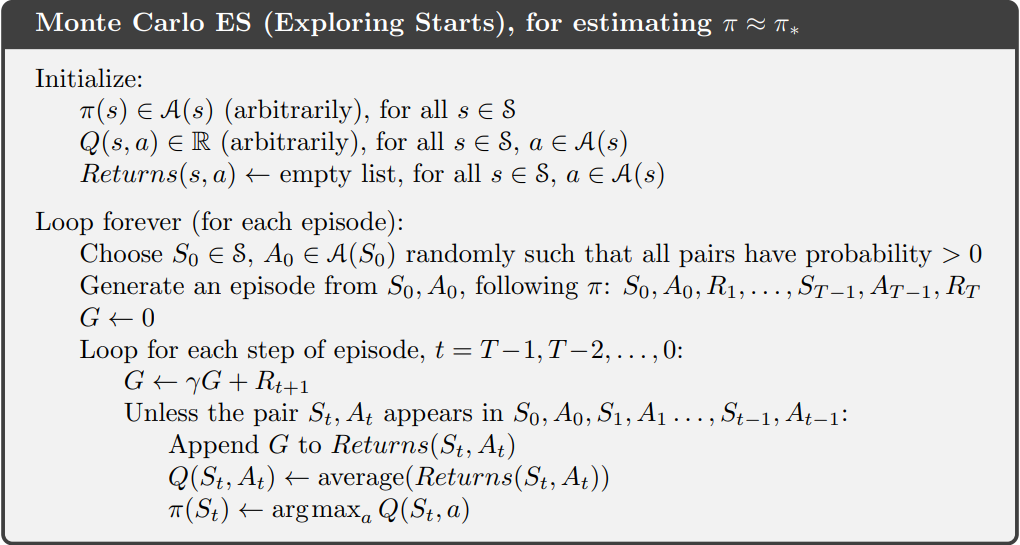

In [21]:
Terminal_States = [[3,4], [4,0]]
V_MC = np.zeros((Grid_size, Grid_size))
step = [[-1,0],[1,0],[0,-1],[0,1]]
Policy = {(i, j): step[np.random.randint(4)] for i in range(Grid_size) for j in range(Grid_size)}

In [22]:
def Generate_Episode(Policy, Current_State, Step_limit  = 1000):
    Episode_list = []
    Step_Count = 0
    while 1:  
        New_Step, Reward = Reward_And_Transition_Part_2([Current_State[0], Current_State[1]], Policy[Current_State[0], Current_State[1]])
        Episode_list.append([Current_State, Policy[Current_State[0], Current_State[1]], Reward])
        Current_State = New_Step
        Step_Count += 1
        if [New_Step[0], New_Step[1]] in Terminal_States or Step_Count > Step_limit:
            break     
    return Episode_list        

In [23]:
def Returns(Episode_list):
    G =  0
    Return_list = []
    for i in range(len(Episode_list)-1, -1, -1):
        G = Episode_list[i][-1] + gamma*G
        Return_list.append([Episode_list[i][0], Episode_list[i][1], G])
    return Return_list

In [24]:
def Update(Return_list, V_MC, Policy, alpha = 0.1):
  Visited = []
  for State, Action, G in Return_list:
    State_tuple = tuple(State)  
    if (State_tuple, Action) not in Visited:
      Visited.append((State_tuple, Action))
      V_MC[(State[0], State[1])] += alpha * (G - V_MC[(State[0], State[1])])
      Best_Reward = 0
      for i in range(len(step)):
        New_Step, Reward = Reward_And_Transition_Part_2([State[0], State[1]], step[i])
        Best_Reward = max(Best_Reward, Reward)
      Policy[State[0], State[1]] = Best_Reward
  return V_MC, Policy

In [25]:
def Monte_Carlo_ES(V_MC, Policy, Num_episodes = 5000):
    for i in range(Num_episodes):
        Start_State = np.random.randint(0, 5, 2)
        Episode_list = Generate_Episode(Policy, Start_State, Step_limit  = 100)
        Return_list = Returns(Episode_list)
        V_MC, Policy = Update(Return_list, V_MC, Policy)
    return V_MC, Policy

In [26]:
V_MC = np.zeros((Grid_size, Grid_size))
step = [[-1,0],[1,0],[0,-1],[0,1]]
Policy = {(i, j): step[np.random.randint(4)] for i in range(Grid_size) for j in range(Grid_size)}
V_MC, Policy = Monte_Carlo_ES(V_MC, Policy, Num_episodes = 3000)

In [27]:
V_MC

array([[-0.20000026,  1.22249422, -0.1999992 , -0.19999834, -1.27750021],
       [-0.20000018, -0.20000108, -0.20000012, -0.19999966, -0.20000057],
       [-0.19999942, -0.19999991, -0.20000079, -0.19999958,  0.        ],
       [-0.20000088, -0.20000071, -0.2       , -0.19999771, -0.19999641],
       [ 0.        , -0.19999809, -0.2       , -0.19999956, -0.2       ]])

##### Monte Carlo E-Greedy

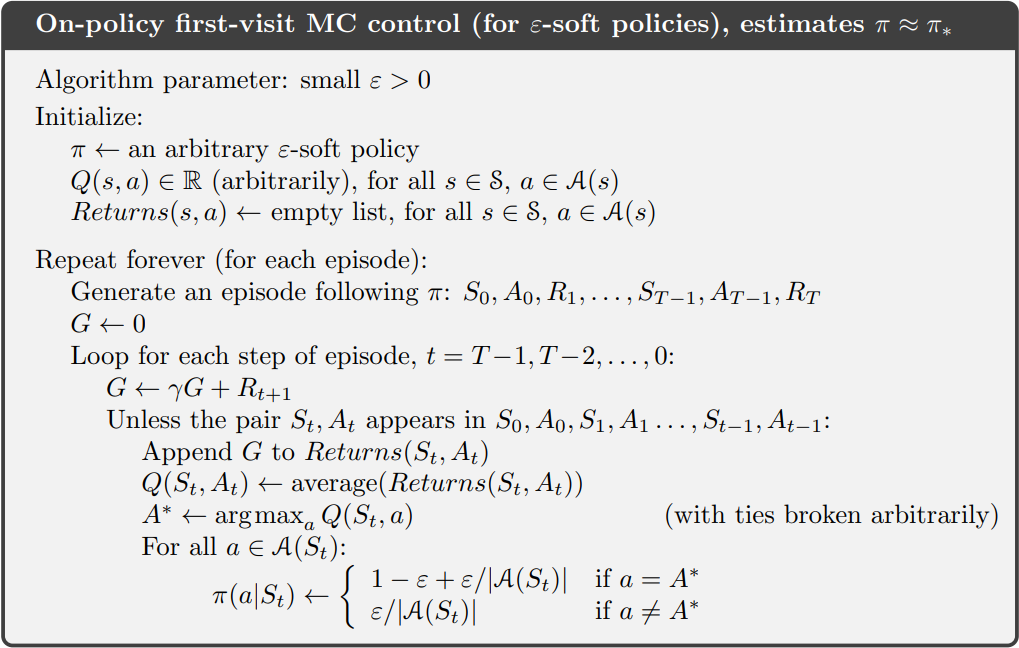

In [29]:
def Generate_Episode_ESoft(Q, Current_State, epsilon = 0.1, Step_limit  = 100):
    Episode_list = []
    Step_Count = 0
    while 1:
        if random.uniform(0, 1) < epsilon:
            Action = step[np.random.randint(4)]   
        else:
            #Get all the values from a state
            values = [Q[(tuple(Current_State), tuple(step[k]))] for k in range(step.shape[0])]
            highest_index = values.index(max(values))
            Action = step[highest_index]
        New_Step, Reward = Reward_And_Transition_Part_2([Current_State[0], Current_State[1]], Action)
        Episode_list.append([Current_State, Action, Reward])
        Current_State = New_Step
        Step_Count += 1
        if [New_Step[0], New_Step[1]] in Terminal_States or Step_Count > Step_limit:
            break     
    return Episode_list  

In [30]:
def Q_N_ESoft(Episode_list, Q, N):
    G =  0
    Visited = []
    for i in range(len(Episode_list)-1, -1, -1):
        G = Episode_list[i][-1] + gamma*G
        if (tuple(Episode_list[i][0]), tuple(Episode_list[i][1])) not in Visited:
            N[(tuple(Episode_list[i][0]), tuple(Episode_list[i][1]))] += 1
            Q[(tuple(Episode_list[i][0]), tuple(Episode_list[i][1]))] += (G - Q[(tuple(Episode_list[i][0]), tuple(Episode_list[i][1]))]) / N[(tuple(Episode_list[i][0]), tuple(Episode_list[i][1]))]
            Visited.append((tuple(Episode_list[i][0]), tuple(Episode_list[i][1])))
    return Q


In [31]:
def Get_Policy(Q, Policy, epsilon = 0.1):
    for i in range(Grid_size):
        for j in range(Grid_size):
            values = [Q[(tuple([i,j]), tuple(step[k]))] for k in range(step.shape[0])]
            highest_index = values.index(max(values))
            if tuple([i,j]) not in Policy:
                Policy[i,j] = {}
            for k in range(step.shape[0]):
                if k == highest_index:
                    Policy[i,j][tuple(step[k])] = (1 - epsilon) + (epsilon/step.shape[0])
                else:
                    Policy[i,j][tuple(step[k])] = (epsilon/step.shape[0])
    return Policy


In [70]:
def Monte_Carlo_ESoft(Q, N, Policy, Num_Episodes = 3000, epsilon = 0.1):
    for i in range(Num_Episodes):
        Start_State = np.random.randint(0, 5, 2)
        Episode_list = Generate_Episode_ESoft(Q, Start_State, epsilon, Step_limit  = 100)
        Q = Q_N_ESoft(Episode_list, Q, N)
        Policy = Get_Policy(Q, Policy, epsilon)
    return Policy, Q

In [33]:
def Plot_Matrix(Q):

    Final_Q_Direction = {}
    Final_Q = {}
    for i in range(Grid_size):
        for j in range(Grid_size):
            values = [Q[(tuple([i,j]), tuple(step[k]))] for k in range(step.shape[0])]
            highest_index = values.index(max(values))
            for k in range(step.shape[0]):
                if k == highest_index:
                    Final_Q[i,j] = Q[(tuple([i,j]), tuple(step[k]))]
                    Final_Q_Direction[i,j] = step_c[k]



# Determine the size of the matrix
    max_x = max(key[0] for key in Final_Q.keys())
    max_y = max(key[1] for key in Final_Q.keys())

    # Initialize an empty matrix
    matrix = np.zeros((max_x + 1, max_y + 1))

    # Fill the matrix with values from the dictionary
    for (x, y), value in Final_Q.items():
        matrix[x, y] = value

    print(matrix)
    # Plot the matrix
    plt.imshow(matrix, cmap='viridis', interpolation='nearest')
    plt.colorbar(label='Value')
    plt.title('Matrix Visualization')
    plt.xlabel('Column')
    plt.ylabel('Row')
    plt.xticks(range(max_y + 1))
    plt.yticks(range(max_x + 1))
    plt.show()
    
    rows = max(key[0] for key in Final_Q_Direction.keys()) + 1
    cols = max(key[1] for key in Final_Q_Direction.keys()) + 1

    matrix = [['' for _ in range(cols)] for _ in range(rows)]

    for (row, col), direction in Final_Q_Direction.items():
        matrix[row][col] = direction

    fig, ax = plt.subplots()
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])

    for i in range(rows):
        for j in range(cols):
            ax.text(j, i, matrix[i][j], va='center', ha='center')

    ax.set_xlim(-0.5, cols - 0.5)
    ax.set_ylim(rows - 0.5, -0.5)

    plt.show()

[[5.29401492 5.56421635 4.80133799 4.15628249 4.63615403]
 [4.23074476 3.82955869 3.48078345 3.26827598 3.98787638]
 [3.47385959 2.87796205 2.3132514  2.37558642 0.        ]
 [2.86189099 1.88363275 0.76694733 1.56762275 2.79200365]
 [0.         1.82178425 1.18528306 1.69215136 2.13641188]]


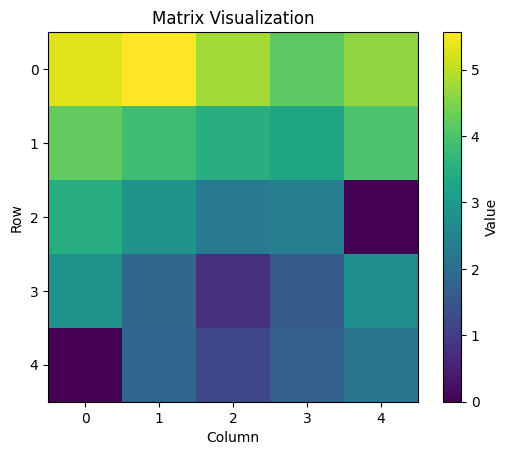

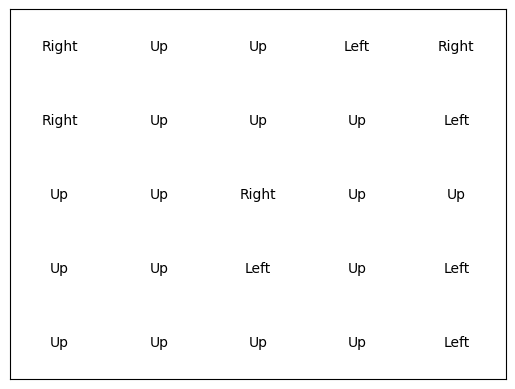

In [71]:
step = np.array([[-1,0],[1,0],[0,-1],[0,1]])

Q = {((i, j),tuple(step[k])): 0.0 for i in range(Grid_size) for j in range(Grid_size) for k in range(step.shape[0])}
N = {((i, j),tuple(step[k])): 0.0 for i in range(Grid_size) for j in range(Grid_size) for k in range(step.shape[0])}
epsilon = 0.1
Policy = {}

Policy, Q = Monte_Carlo_ESoft(Q, N, Policy, 100000)
Plot_Matrix(Q)

2. Now use a behaviour policy with equiprobable moves to learn an optimal policy. Note here the dynamics of the world are known exactly, so you can actually compute the importance weights needed for this.

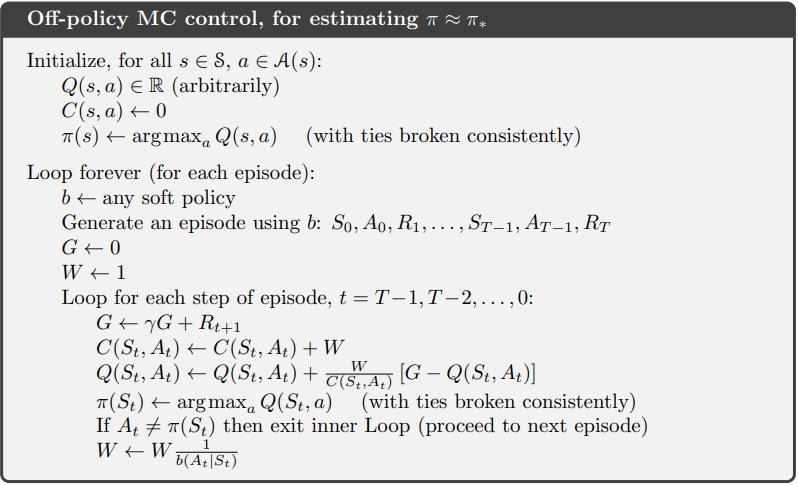

In [104]:
def GET_W_and_Policy(Episode_list, Q, C, Policy):
    G =  0
    W = 1
    for i in range(len(Episode_list)-1, -1, -1):
        G = Episode_list[i][-1] + gamma*G
        C[(tuple(Episode_list[i][0]), tuple(Episode_list[i][1]))] = C[(tuple(Episode_list[i][0]), tuple(Episode_list[i][1]))] + W
        Q[(tuple(Episode_list[i][0]), tuple(Episode_list[i][1]))] = Q[(tuple(Episode_list[i][0]), tuple(Episode_list[i][1]))] + (W/C[(tuple(Episode_list[i][0]), tuple(Episode_list[i][1]))]) * (G - Q[(tuple(Episode_list[i][0]), tuple(Episode_list[i][1]))])       
        aux_list = [Q[tuple(Episode_list[i][0]), (-1,0)], Q[tuple(Episode_list[i][0]), (1,0)], Q[tuple(Episode_list[i][0]), (0,1)], Q[tuple(Episode_list[i][0]), (0,-1)]]
        aux_index = aux_list.index(max(aux_list))
        Policy[tuple(Episode_list[i][0])] = step[aux_index] 
        if tuple(Episode_list[i][1]) == tuple(Policy[tuple(Episode_list[i][0])]):
            W = W * 2
    return Policy

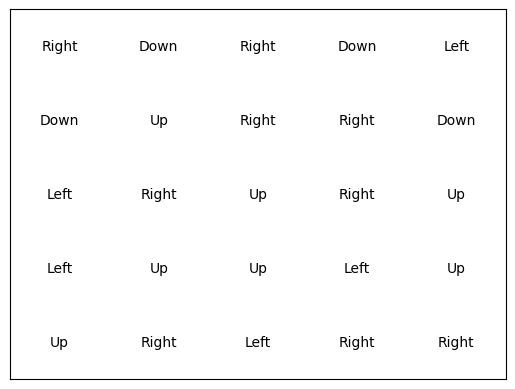

In [105]:
Q = {((i, j),tuple(step[k])): 0.0 for i in range(Grid_size) for j in range(Grid_size) for k in range(step.shape[0])}
C = {((i, j),tuple(step[k])): 0.0 for i in range(Grid_size) for j in range(Grid_size) for k in range(step.shape[0])}
Policy = {((i, j)): [0,0] for i in range(Grid_size) for j in range(Grid_size)}
for i in range(5000):
    Start_State = np.random.randint(0, 5, 2)
    Episode_list = Generate_Episode_ESoft(Q, Start_State, epsilon, Step_limit  = 100)
    Policy = GET_W_and_Policy(Episode_list, Q, C, Policy)
Plot_Policy(Policy)

3. Finally, let’s suppose that at every step, we permute the locations of the green and blue squares with probability 0.1, while preserving the rewards and transition structure as before. Use policy iteration to determine a suitable policy for this environment. How does it differ from the case where the squares stay where they are? This is a bit more of an open-ended question for you to think about how to address such problems.


In [124]:
def Reward_And_Transition_Part_2_Random(Current_Step, Action, Current_Green, Currrent_Blue):
    if random.uniform(0, 1) < 0.1:
        Current_Green = [np.random.randint(5),np.random.randint(5)]
        Current_Blue = [np.random.randint(5),np.random.randint(5)]   

    if Current_Step == Current_Blue:
        Next_Step = [3,2]
        Reward = 5
        return  Next_Step, Reward
    
    elif Current_Step == Current_Green:
        Next_Step = random.choice([[4,2],[4,4]])
        Reward = 2.5
        return  Next_Step, Reward
    
    elif Current_Step == [2,4]:
        Next_Step = [2,4]
        Reward = 0
        return  Next_Step, Reward
    
    elif Current_Step == [4,0]:
        Next_Step = [4,0]
        Reward = 0
        return  Next_Step, Reward
    
    Next_Step = list(np.add(Current_Step, Action))

    if Next_Step[0] < 0 or Next_Step[0] > 4 or Next_Step[1] < 0 or Next_Step[1] > 4:
        Reward = -0.5
        return Current_Step, Reward
    
    Reward = -0.2

    return Next_Step, Reward, Current_Blue, Current_Green

In [125]:
def Generate_Episode_Random(Policy, Current_State, Step_limit  = 1000):
    Episode_list = []
    Step_Count = 0
    Current_Green = [0,4]
    Current_Blue = [0,1]
    while 1:  
        New_Step, Reward, Current_Blue, Current_Green = Reward_And_Transition_Part_2([Current_State[0], Current_State[1]], Policy[Current_State[0], Current_State[1]], Current_Blue, Current_Green)
        Episode_list.append([Current_State, Policy[Current_State[0], Current_State[1]], Reward])
        Current_State = New_Step
        Step_Count += 1
        if [New_Step[0], New_Step[1]] in Terminal_States or Step_Count > Step_limit:
            break     
    return Episode_list  

In [126]:
def Monte_Carlo_Random(V_MC, Policy, Num_episodes = 5000):
    for i in range(Num_episodes):
        Start_State = np.random.randint(0, 5, 2)
        Episode_list = Generate_Episode_Random(Policy, Start_State, Step_limit  = 100)
        Return_list = Returns(Episode_list)
        V_MC, Policy = Update(Return_list, V_MC, Policy)
    return V_MC, Policy

In [131]:
V_Random = np.zeros((Grid_size, Grid_size))
step = [[-1,0],[1,0],[0,-1],[0,1]]
Policy_Random = {(i, j): step[np.random.randint(4)] for i in range(Grid_size) for j in range(Grid_size)}
V_Random, Policy_Random = Monte_Carlo_ES(V_Random, Policy, Num_episodes = 20000)

In [132]:
V_Random

array([[-0.2       ,  1.22249801, -0.2       , -0.2       , -1.27750199],
       [-0.2       , -0.2       , -0.2       , -0.2       , -0.2       ],
       [-0.2       , -0.2       , -0.2       , -0.2       ,  0.        ],
       [-0.2       , -0.2       , -0.2       , -0.2       , -0.2       ],
       [ 0.        , -0.2       , -0.2       , -0.2       , -0.2       ]])

All the white cells have a reward of -0.2 and the blue one and green one had lower reward than than what actually they provide. Black (End) cells remain with reward 0. 